<a href="https://colab.research.google.com/github/nguyen-nhat-mai/ile-de-france-apartment-price-prediction/blob/main/Ile-de-france-apartment-price-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import norm
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from statistics import mean
from sklearn.ensemble import GradientBoostingRegressor

# Import data & add additional data

**Extract data**

In [ ]:
# Import & combine all data
df1 = pd.read_csv('mutations_d75_train.csv')
df2 = pd.read_csv('mutations_d77_train.csv')
df3 = pd.read_csv('mutations_d78_train.csv')
df4 = pd.read_csv('mutations_d91_train.csv')
df5 = pd.read_csv('mutations_d92_train.csv')
df6 = pd.read_csv('mutations_d93_train.csv')
df7 = pd.read_csv('mutations_d94_train.csv')
df8 = pd.read_csv('mutations_d95_train.csv')
data = [df1,df2,df3,df4,df5,df6,df7,df8]
df = pd.concat(data)
df = df.iloc[:,2:] # remove 2 index columns
df=df.drop(['codservch', 'refdoc'], axis=1) # these 2 columns only contain null
df.head()

,idmutation,idmutinvar,idopendata,idnatmut,datemut,anneemut,moismut,coddep,libnatmut,vefa,...,sapt3pp,sapt4pp,sapt5pp,smai1pp,smai2pp,smai3pp,smai4pp,smai5pp,codtypbien,libtypbien
0,6539278.0,9b7b4d9b9700ca770f3f498b5d69eaf3,9b7b4d9b9700ca770f3f498b5d69eaf3,1.0,2018-04-06,2018.0,4.0,75.0,Vente,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121.0,UN APPARTEMENT
1,6660956.0,3c49a78206ac11f9695bad48967f898e,3c49a78206ac11f9695bad48967f898e,1.0,2017-07-06,2017.0,7.0,75.0,Vente,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121.0,UN APPARTEMENT
2,6374603.0,43db5a7809b243060479e1bca9def379,43db5a7809b243060479e1bca9def379,1.0,2019-07-18,2019.0,7.0,75.0,Vente,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,131.0,UNE DEPENDANCE
3,6393753.0,7bba166c612dfbd6c0694a2ab3209bab,7bba166c612dfbd6c0694a2ab3209bab,1.0,2019-05-16,2019.0,5.0,75.0,Vente,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,ACTIVITE
4,7090098.0,24b9ace5aaea518ba15bd43c0ffc6141,24b9ace5aaea518ba15bd43c0ffc6141,1.0,2014-05-14,2014.0,5.0,75.0,Vente,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,131.0,UNE DEPENDANCE


In [ ]:
# Extract insee code & id_parcel
df['insee_code'] = df['l_codinsee'].str[2:7]
df['id_parcel'] = df['l_idpar'].str.strip("['']")
split_id_parcel = df['id_parcel'].str.split("'",n = 1, expand = True)
df['id_parcel_adj'] = split_id_parcel[0] # some mutation contains more than 1 id_parcel, these are adjacent => take the 1st id_parcel to extract geolocation
df.head()

,idmutation,idmutinvar,idopendata,idnatmut,datemut,anneemut,moismut,coddep,libnatmut,vefa,...,smai1pp,smai2pp,smai3pp,smai4pp,smai5pp,codtypbien,libtypbien,insee_code,id_parcel,id_parcel_adj
0,6539278.0,9b7b4d9b9700ca770f3f498b5d69eaf3,9b7b4d9b9700ca770f3f498b5d69eaf3,1.0,2018-04-06,2018.0,4.0,75.0,Vente,False,...,0.0,0.0,0.0,0.0,0.0,121.0,UN APPARTEMENT,75102,75102000AI0121,75102000AI0121
1,6660956.0,3c49a78206ac11f9695bad48967f898e,3c49a78206ac11f9695bad48967f898e,1.0,2017-07-06,2017.0,7.0,75.0,Vente,False,...,0.0,0.0,0.0,0.0,0.0,121.0,UN APPARTEMENT,75111,75111000AL0036,75111000AL0036
2,6374603.0,43db5a7809b243060479e1bca9def379,43db5a7809b243060479e1bca9def379,1.0,2019-07-18,2019.0,7.0,75.0,Vente,False,...,0.0,0.0,0.0,0.0,0.0,131.0,UNE DEPENDANCE,75111,75111000AB0014,75111000AB0014
3,6393753.0,7bba166c612dfbd6c0694a2ab3209bab,7bba166c612dfbd6c0694a2ab3209bab,1.0,2019-05-16,2019.0,5.0,75.0,Vente,False,...,0.0,0.0,0.0,0.0,0.0,14.0,ACTIVITE,75104,75104000AJ0102,75104000AJ0102
4,7090098.0,24b9ace5aaea518ba15bd43c0ffc6141,24b9ace5aaea518ba15bd43c0ffc6141,1.0,2014-05-14,2014.0,5.0,75.0,Vente,False,...,0.0,0.0,0.0,0.0,0.0,131.0,UNE DEPENDANCE,75108,75108000BF0024,75108000BF0024


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1271568 entries, 0 to 127378
Data columns (total 59 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   idmutation     1271568 non-null  float64
 1   idmutinvar     1271568 non-null  object 
 2   idopendata     1271568 non-null  object 
 3   idnatmut       1271568 non-null  float64
 4   datemut        1271568 non-null  object 
 5   anneemut       1271568 non-null  float64
 6   moismut        1271568 non-null  float64
 7   coddep         1271568 non-null  float64
 8   libnatmut      1271568 non-null  object 
 9   vefa           1271568 non-null  bool   
 10  valeurfonc     1270565 non-null  float64
 11  nbdispo        1271568 non-null  float64
 12  nblot          1271568 non-null  float64
 13  nbcomm         1271568 non-null  float64
 14  l_codinsee     1271568 non-null  object 
 15  nbsection      1271568 non-null  float64
 16  l_section      1271568 non-null  object 
 17  nbpar    

**Add geolocalisation**

In [ ]:
# Read the parcel mapping file
parcel_map = pd.read_csv('parcel_map_1.csv')
parcel_map = parcel_map.drop_duplicates(subset=["Identifiant de la parcelle cadastrale"]) # some parcel_id has very small different in geolocation => keep only 1
print(parcel_map.info())
parcel_map

<class 'pandas.core.frame.DataFrame'>
Int64Index: 709229 entries, 0 to 724455
Data columns (total 4 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Identifiant de la parcelle cadastrale  709229 non-null  object 
 1   Longitude                              686571 non-null  float64
 2   Latitude                               686571 non-null  float64
 3   Géolocalisation                        686571 non-null  object 
dtypes: float64(2), object(2)
memory usage: 27.1+ MB
None


,Identifiant de la parcelle cadastrale,Longitude,Latitude,Géolocalisation
0,774470000C0242,2.552813,48.542406,"48.542406, 2.552813"
1,774470000C0256,2.551254,48.542549,"48.542549, 2.551254"
2,77350000BD0025,2.665089,48.761979,"48.761979, 2.665089"
3,772960000A1659,2.598156,48.628214,"48.628214, 2.598156"
4,77450000AK0162,2.607617,48.718140,"48.71814, 2.607617"
...,...,...,...,...
724451,914630000B2230,2.472079,48.387460,"48.38746, 2.472079"
724452,91129000AM0285,2.328939,48.481228,"48.481228, 2.328939"
724453,91533000AK0104,2.117712,48.360059,"48.360059, 2.117712"
724454,91232000AB0452,2.348920,48.480636,"48.480636, 2.34892"


In [ ]:
# Map the geolocation using the id_parcel
map_parcel_df = pd.merge(df, parcel_map,how='left',left_on='id_parcel_adj', right_on='Identifiant de la parcelle cadastrale')
map_parcel_df

,idmutation,idmutinvar,idopendata,idnatmut,datemut,anneemut,moismut,coddep,libnatmut,vefa,...,smai5pp,codtypbien,libtypbien,insee_code,id_parcel,id_parcel_adj,Identifiant de la parcelle cadastrale,Longitude,Latitude,Géolocalisation
0,6539278.0,9b7b4d9b9700ca770f3f498b5d69eaf3,9b7b4d9b9700ca770f3f498b5d69eaf3,1.0,2018-04-06,2018.0,4.0,75.0,Vente,False,...,0.0,121.0,UN APPARTEMENT,75102,75102000AI0121,75102000AI0121,75102000AI0121,2.347376,48.868226,"48.868226, 2.347376"
1,6660956.0,3c49a78206ac11f9695bad48967f898e,3c49a78206ac11f9695bad48967f898e,1.0,2017-07-06,2017.0,7.0,75.0,Vente,False,...,0.0,121.0,UN APPARTEMENT,75111,75111000AL0036,75111000AL0036,75111000AL0036,2.374806,48.866855,"48.866855, 2.374806"
2,6374603.0,43db5a7809b243060479e1bca9def379,43db5a7809b243060479e1bca9def379,1.0,2019-07-18,2019.0,7.0,75.0,Vente,False,...,0.0,131.0,UNE DEPENDANCE,75111,75111000AB0014,75111000AB0014,75111000AB0014,2.369297,48.866891,"48.866891, 2.369297"
3,6393753.0,7bba166c612dfbd6c0694a2ab3209bab,7bba166c612dfbd6c0694a2ab3209bab,1.0,2019-05-16,2019.0,5.0,75.0,Vente,False,...,0.0,14.0,ACTIVITE,75104,75104000AJ0102,75104000AJ0102,75104000AJ0102,2.357911,48.856445,"48.856445, 2.357911"
4,7090098.0,24b9ace5aaea518ba15bd43c0ffc6141,24b9ace5aaea518ba15bd43c0ffc6141,1.0,2014-05-14,2014.0,5.0,75.0,Vente,False,...,0.0,131.0,UNE DEPENDANCE,75108,75108000BF0024,75108000BF0024,75108000BF0024,2.303693,48.873245,"48.873245, 2.303693"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271563,8650226.0,4f7be20ed59b938220b003b40a91e18d,4f7be20ed59b938220b003b40a91e18d,1.0,2018-05-02,2018.0,5.0,95.0,Vente,False,...,0.0,229.0,TERRAIN ARTIFICIALISE MIXTE,95277,95277000AI0190,95277000AI0190,95277000AI0190,2.446146,48.988616,"48.988616, 2.446146"
1271564,8534218.0,9e943300f649d2949bdad0a3c53971c4,9e943300f649d2949bdad0a3c53971c4,1.0,2020-03-04,2020.0,3.0,95.0,Vente,False,...,140.0,111.0,UNE MAISON,95306,95306000BH0382,95306000BH0382,95306000BH0382,2.157751,48.996099,"48.996099, 2.157751"
1271565,8829533.0,f23be79a1e3b8dd5c7073828e92952f2,f23be79a1e3b8dd5c7073828e92952f2,1.0,2015-03-09,2015.0,3.0,95.0,Vente,False,...,80.0,111.0,UNE MAISON,95051,95051000AI0393,95051000AI0393,95051000AI0393,2.202160,49.006948,"49.006948, 2.20216"
1271566,8830339.0,380ed8919d17bdfd4ca22ba8aaf34498,380ed8919d17bdfd4ca22ba8aaf34498,1.0,2015-01-30,2015.0,1.0,95.0,Vente,False,...,0.0,121.0,UN APPARTEMENT,95210,95210000AH0250,95210000AH0250,95210000AH0250,2.295311,48.969877,"48.969877, 2.295311"


In [ ]:
# check the number of rows with null geolocation info
filtered_df = map_parcel_df[map_parcel_df['Latitude'].isnull()]
print("data without geolocation info",round(len(filtered_df)/len(map_parcel_df)*100,2),"%")
filtered_df

data without geolocation info 0.34 %


,idmutation,idmutinvar,idopendata,idnatmut,datemut,anneemut,moismut,coddep,libnatmut,vefa,...,smai5pp,codtypbien,libtypbien,insee_code,id_parcel,id_parcel_adj,Identifiant de la parcelle cadastrale,Longitude,Latitude,Géolocalisation
1974,6533021.0,316dada1627d92038606ab90927bcdc2,316dada1627d92038606ab90927bcdc2,1.0,2018-07-23,2018.0,7.0,75.0,Vente,False,...,0.0,121.0,UN APPARTEMENT,75119,75119000AI0060,75119000AI0060,75119000AI0060,NaN,NaN,NaN
7312,6259590.0,f12453d05d91eb847b9f4491714c06ef,f12453d05d91eb847b9f4491714c06ef,1.0,2020-06-26,2020.0,6.0,75.0,Vente,False,...,0.0,131.0,UNE DEPENDANCE,75117,75117000AR0067,75117000AR0067,75117000AR0067,NaN,NaN,NaN
59855,6673323.0,3b20ebd0e616c7191f69af31f4366dac,3b20ebd0e616c7191f69af31f4366dac,1.0,2017-07-17,2017.0,7.0,75.0,Vente,False,...,0.0,229.0,TERRAIN ARTIFICIALISE MIXTE,75112,75112000AE0072,75112000AE0072,75112000AE0072,NaN,NaN,NaN
68297,6693476.0,4f903b49177362c4ccbcba4bca8dc559,4f903b49177362c4ccbcba4bca8dc559,1.0,2017-12-01,2017.0,12.0,75.0,Vente,False,...,0.0,121.0,UN APPARTEMENT,75112,75112000CP0008,75112000CP0008,75112000CP0008,NaN,NaN,NaN
90393,6671852.0,ae7a605de96c611f6c8793e668e270cb,ae7a605de96c611f6c8793e668e270cb,1.0,2017-11-03,2017.0,11.0,75.0,Vente,False,...,0.0,121.0,UN APPARTEMENT,75111,75111000AX0031,75111000AX0031,75111000AX0031,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1271167,8867934.0,cc8f50c06df0f540921bfc8b8b67535b,cc8f50c06df0f540921bfc8b8b67535b,1.0,2014-06-12,2014.0,6.0,95.0,Vente,False,...,0.0,21.0,TERRAIN DE TYPE TAB,95102,"95102000AD0210', '95102000AD0248', '95102000AD...",95102000AD0210,95102000AD0210,NaN,NaN,NaN
1271175,8713199.0,5b992b1b3c9440e4d2a16088a36025e0,5b992b1b3c9440e4d2a16088a36025e0,1.0,2017-06-27,2017.0,6.0,95.0,Vente,False,...,0.0,221.0,TERRAIN D'AGREMENT,95428,"95428000AH0438', '95428000AH0439",95428000AH0438,95428000AH0438,NaN,NaN,NaN
1271217,8880228.0,501ef3e8d356e784e2aeb1f1d8c7745c,501ef3e8d356e784e2aeb1f1d8c7745c,4.0,2014-12-22,2014.0,12.0,95.0,Vente terrain à bâtir,False,...,0.0,21.0,TERRAIN DE TYPE TAB,95183,"95183000HL0246', '95183000HL0260', '95183000HL...",95183000HL0246,95183000HL0246,NaN,NaN,NaN
1271295,8829952.0,54f291f47f786023cf8bdcb807e09ca6,54f291f47f786023cf8bdcb807e09ca6,2.0,2015-06-23,2015.0,6.0,95.0,Vente en l'état futur d'achèvement,True,...,197.0,111.0,UNE MAISON,95218,"95218000AB0394', '95218000AB0491', '95218000AB...",95218000AB0394,95218000AB0394,NaN,NaN,NaN


In [ ]:
# drop rows without geolocation info because they are minor
map_parcel_df = map_parcel_df.dropna(axis=0, subset=['Géolocalisation'])
map_parcel_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1267219 entries, 0 to 1271567
Data columns (total 63 columns):
 #   Column                                 Non-Null Count    Dtype  
---  ------                                 --------------    -----  
 0   idmutation                             1267219 non-null  float64
 1   idmutinvar                             1267219 non-null  object 
 2   idopendata                             1267219 non-null  object 
 3   idnatmut                               1267219 non-null  float64
 4   datemut                                1267219 non-null  object 
 5   anneemut                               1267219 non-null  float64
 6   moismut                                1267219 non-null  float64
 7   coddep                                 1267219 non-null  float64
 8   libnatmut                              1267219 non-null  object 
 9   vefa                                   1267219 non-null  bool   
 10  valeurfonc                             126

**Add demographic & additional geographic info**

source: [opendatasoft](https://public.opendatasoft.com/explore/dataset/correspondance-code-insee-code-postal/table/)

In [ ]:
insee_map = pd.read_excel('correspondance-code-insee-code-postal.xlsx')
dep_code = ['75','77','78','91','92','93','94','95'] 
insee_map = insee_map[insee_map['Code Département'].isin(dep_code)]
insee_map.head()

,Code INSEE,Code Postal,Commune,Département,Région,Statut,Altitude Moyenne,Superficie,Population,geo_point_2d,geo_shape,ID Geofla,Code Commune,Code Canton,Code Arrondissement,Code Département,Code Région
51,77128,77860,COUILLY-PONT-AUX-DAMES,SEINE-ET-MARNE,ILE-DE-FRANCE,Commune simple,74.0,475.0,2.1,"48.88166983746127, 2.8653400028622302","{""coordinates"":[[[2.876514411282743,48.8657786...",7722,128,8,1,77,11
89,93008,93000,BOBIGNY,SEINE-SAINT-DENIS,ILE-DE-FRANCE,Préfecture,48.0,674.0,48.5,"48.907688243955754, 2.438639827268387","{""coordinates"":[[[2.4277240402745033,48.895887...",12799,8,7,1,93,11
97,78505,78910,PRUNAY-LE-TEMPLE,YVELINES,ILE-DE-FRANCE,Commune simple,115.0,674.0,0.4,"48.859289814279144, 1.671301146657966","{""coordinates"":[[[1.6589144112971872,48.841634...",15482,505,8,1,78,11
170,77204,77840,GERMIGNY-SOUS-COULOMBS,SEINE-ET-MARNE,ILE-DE-FRANCE,Commune simple,145.0,650.0,0.2,"49.06439549290524, 3.161414639163483","{""coordinates"":[[[3.157786921345649,49.0474477...",35036,204,15,1,77,11
183,95241,95190,FONTENAY-EN-PARISIS,VAL-D'OISE,ILE-DE-FRANCE,Commune simple,112.0,1096.0,1.9,"49.05011966308222, 2.445393719277551","{""coordinates"":[[[2.4381978296547633,49.028721...",25433,241,15,2,95,11


In [ ]:
# Extract region demographic & geographic info such as Statut, Altitude Moyenne, Superficie, Population
insee_map = insee_map[['Code INSEE','Statut', 'Altitude Moyenne', 'Superficie', 'Population']]
insee_map

,Code INSEE,Statut,Altitude Moyenne,Superficie,Population
51,77128,Commune simple,74.0,475.0,2.1
89,93008,Préfecture,48.0,674.0,48.5
97,78505,Commune simple,115.0,674.0,0.4
170,77204,Commune simple,145.0,650.0,0.2
183,95241,Commune simple,112.0,1096.0,1.9
...,...,...,...,...,...
36683,75114,Chef-lieu canton,63.0,560.0,137.2
36688,77506,Commune simple,83.0,1857.0,0.7
36717,95387,Commune simple,90.0,273.0,0.1
36720,94055,Chef-lieu canton,91.0,344.0,9.9


In [ ]:
# Map the region demographic & geographic info into the data
map_df = pd.merge(map_parcel_df, insee_map,how='left',left_on='insee_code', right_on='Code INSEE')
map_df = map_df.drop(columns=['Identifiant de la parcelle cadastrale', 'Code INSEE'])
map_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1267219 entries, 0 to 1267218
Data columns (total 66 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   idmutation        1267219 non-null  float64
 1   idmutinvar        1267219 non-null  object 
 2   idopendata        1267219 non-null  object 
 3   idnatmut          1267219 non-null  float64
 4   datemut           1267219 non-null  object 
 5   anneemut          1267219 non-null  float64
 6   moismut           1267219 non-null  float64
 7   coddep            1267219 non-null  float64
 8   libnatmut         1267219 non-null  object 
 9   vefa              1267219 non-null  bool   
 10  valeurfonc        1266252 non-null  float64
 11  nbdispo           1267219 non-null  float64
 12  nblot             1267219 non-null  float64
 13  nbcomm            1267219 non-null  float64
 14  l_codinsee        1267219 non-null  object 
 15  nbsection         1267219 non-null  float64
 16  

In [ ]:
# Filter out data with 1) libtypbien contains "APPARTEMENT" & 2) vefa = True
map_df = map_df[map_df['libtypbien'].str.contains("APPARTEMENT")]
map_df = map_df[map_df['vefa']==True]
map_df = map_df.dropna(axis=0, subset=['valeurfonc']) # delete 2 rows without price info
map_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19654 entries, 511 to 1267204
Data columns (total 66 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   idmutation        19654 non-null  float64
 1   idmutinvar        19654 non-null  object 
 2   idopendata        19654 non-null  object 
 3   idnatmut          19654 non-null  float64
 4   datemut           19654 non-null  object 
 5   anneemut          19654 non-null  float64
 6   moismut           19654 non-null  float64
 7   coddep            19654 non-null  float64
 8   libnatmut         19654 non-null  object 
 9   vefa              19654 non-null  bool   
 10  valeurfonc        19654 non-null  float64
 11  nbdispo           19654 non-null  float64
 12  nblot             19654 non-null  float64
 13  nbcomm            19654 non-null  float64
 14  l_codinsee        19654 non-null  object 
 15  nbsection         19654 non-null  float64
 16  l_section         19654 non-null  ob

In [ ]:
# After filtering out unrelated data, some columns only contain 1 distinct value => delete
for col in map_df.columns:
    if len(map_df[col].unique()) == 1:
        map_df.drop(col,inplace=True,axis=1)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
map_df['libtypbien'].unique()

array(['UN APPARTEMENT', 'DEUX APPARTEMENTS', 'APPARTEMENT INDETERMINE'],
      dtype=object)

In [ ]:
# add price/ sqm
map_df['price/sqm'] = map_df['valeurfonc']/map_df['sbatapt']
map_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19654 entries, 511 to 1267204
Data columns (total 49 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   idmutation        19654 non-null  float64
 1   idmutinvar        19654 non-null  object 
 2   idopendata        19654 non-null  object 
 3   datemut           19654 non-null  object 
 4   anneemut          19654 non-null  float64
 5   moismut           19654 non-null  float64
 6   coddep            19654 non-null  float64
 7   valeurfonc        19654 non-null  float64
 8   nbdispo           19654 non-null  float64
 9   nblot             19654 non-null  float64
 10  nbcomm            19654 non-null  float64
 11  l_codinsee        19654 non-null  object 
 12  nbsection         19654 non-null  float64
 13  l_section         19654 non-null  object 
 14  nbpar             19654 non-null  float64
 15  l_idpar           19654 non-null  object 
 16  nbparmut          19654 non-null  fl

# Explore the data

In [ ]:
map_df.describe()

,idmutation,anneemut,moismut,coddep,valeurfonc,nbdispo,nblot,nbcomm,nbsection,nbpar,...,sapt3pp,sapt4pp,sapt5pp,codtypbien,Longitude,Latitude,Altitude Moyenne,Superficie,Population,price/sqm
count,1.965400e+04,19654.000000,19654.00000,19654.000000,1.965400e+04,19654.000000,19654.000000,19654.000000,19654.000000,19654.000000,...,19654.000000,19654.000000,19654.000000,19654.000000,19654.000000,19654.000000,19654.000000,19654.000000,19654.000000,1.965400e+04
mean,7.976131e+06,2016.489315,6.90114,88.488654,3.038325e+05,1.001679,2.365167,1.000153,1.002391,1.041213,...,25.956039,14.795207,3.067772,121.002595,2.368718,48.838918,74.418999,825.136817,41.071003,inf
std,7.858813e+05,1.781696,3.55351,7.213949,3.814495e+05,0.040943,3.269771,0.012354,0.048844,0.231211,...,50.568187,36.423224,19.584733,0.120395,0.209864,0.126028,32.862501,954.500811,35.899914,NaN
min,6.227416e+06,2014.000000,1.00000,75.000000,1.000000e+00,1.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,120.000000,1.596547,48.262483,24.000000,69.000000,0.500000,1.250000e-02
25%,7.123008e+06,2015.000000,4.00000,78.000000,1.860025e+05,1.000000,2.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,121.000000,2.243396,48.786363,46.000000,432.000000,17.500000,3.710036e+03
50%,8.274108e+06,2017.000000,7.00000,92.000000,2.420000e+05,1.000000,2.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,121.000000,2.367587,48.852053,69.000000,666.000000,31.000000,4.376867e+03
75%,8.517199e+06,2018.000000,10.00000,94.000000,3.295000e+05,1.000000,3.000000,1.000000,1.000000,1.000000,...,60.000000,0.000000,0.000000,121.000000,2.499717,48.919666,91.000000,1042.000000,53.400000,5.607003e+03
max,8.881379e+06,2020.000000,12.00000,95.000000,2.281696e+07,2.000000,180.000000,2.000000,2.000000,9.000000,...,2089.000000,1041.000000,974.000000,122.000000,3.283792,49.156406,170.000000,17237.000000,236.500000,inf


In [ ]:
# 6 rows don't have the value in sbatapt, we remove
map_df = map_df[map_df['sbatapt']>0]

In [ ]:
# check outliers through price/sqm
map_df["price/sqm"].describe()

count     19648.000000
mean       4956.547326
std        3630.928017
min           0.012500
25%        3709.672699
50%        4376.316937
75%        5604.664265
max      422536.222222
Name: price/sqm, dtype: float64

In [ ]:
# Check number of rows outside normal range
outlier = map_df[(map_df['price/sqm']>16000)|(map_df['price/sqm']<1500)]
outlier[['sbatapt','valeurfonc','price/sqm']]

,sbatapt,valeurfonc,price/sqm
5332,69.0,5000.00,72.463768
21279,57.0,980000.00,17192.982456
25981,19.0,325000.00,17105.263158
31899,19.0,307000.00,16157.894737
39492,86.0,5000.00,58.139535
...,...,...,...
1143492,59.0,9300.00,157.627119
1167833,67.0,1500.00,22.388060
1219134,63.0,3010.03,47.778254
1222084,64.0,3000.00,46.875000


In [ ]:
# adjust the price/sqm into the range [1,500-16,000]
map_df['adj_price_sqm'] = np.where(map_df['price/sqm'] > 16000, 16000, map_df['price/sqm'])
map_df['adj_price_sqm'] = np.where(map_df['adj_price_sqm'] < 1500, 1500, map_df['adj_price_sqm'])
map_df["adj_price_sqm"].describe()

count    19648.000000
mean      4932.111344
std       1906.381655
min       1500.000000
25%       3709.672699
50%       4376.316937
75%       5604.664265
max      16000.000000
Name: adj_price_sqm, dtype: float64

In [ ]:
# adjust the price (valeurfonc) in accordance
map_df['adj_price'] = map_df["adj_price_sqm"] * map_df['sbatapt']
map_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19648 entries, 511 to 1267204
Data columns (total 51 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   idmutation        19648 non-null  float64
 1   idmutinvar        19648 non-null  object 
 2   idopendata        19648 non-null  object 
 3   datemut           19648 non-null  object 
 4   anneemut          19648 non-null  float64
 5   moismut           19648 non-null  float64
 6   coddep            19648 non-null  float64
 7   valeurfonc        19648 non-null  float64
 8   nbdispo           19648 non-null  float64
 9   nblot             19648 non-null  float64
 10  nbcomm            19648 non-null  float64
 11  l_codinsee        19648 non-null  object 
 12  nbsection         19648 non-null  float64
 13  l_section         19648 non-null  object 
 14  nbpar             19648 non-null  float64
 15  l_idpar           19648 non-null  object 
 16  nbparmut          19648 non-null  fl

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


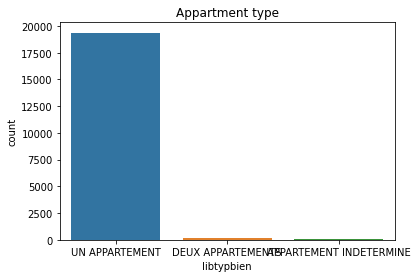

In [ ]:
# appartment type count plot
ax = sns.countplot('libtypbien',data=map_df,order=map_df['libtypbien'].value_counts().index)
ax.set_title('Appartment type')
plt.show()

Text(0.5, 1.0, 'Price distribution for each appartment type')

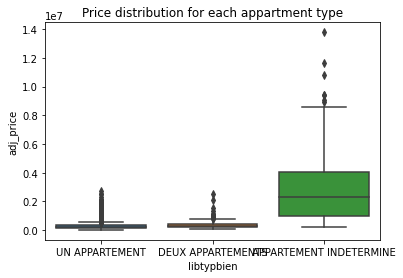

In [ ]:
# price by appartment type
ax = sns.boxplot(data=map_df, x='libtypbien', y='adj_price')
ax.set_title('Price distribution for each appartment type')

In [ ]:
# split data into Numerical data & Categorical data
def split_num_cat(data):
    num_data = data.select_dtypes(exclude=['object'])
    cat_data = data.select_dtypes(include=['object'])
    return num_data, cat_data

train_num, train_cat = split_num_cat(map_df)
train_num = train_num.drop(columns=['valeurfonc'])
print(train_num.columns)
print(train_cat.columns) # cat versions of numerical variables or unimportant features => not consider

Index(['idmutation', 'anneemut', 'moismut', 'coddep', 'nbdispo', 'nblot',
       'nbcomm', 'nbsection', 'nbpar', 'nbparmut', 'nbsuf', 'sterr',
       'nblocmut', 'nblocapt', 'nblocdep', 'nbapt1pp', 'nbapt2pp', 'nbapt3pp',
       'nbapt4pp', 'nbapt5pp', 'sbati', 'sbatapt', 'sapt1pp', 'sapt2pp',
       'sapt3pp', 'sapt4pp', 'sapt5pp', 'codtypbien', 'Longitude', 'Latitude',
       'Altitude Moyenne', 'Superficie', 'Population', 'price/sqm',
       'adj_price_sqm', 'adj_price'],
      dtype='object')
Index(['idmutinvar', 'idopendata', 'datemut', 'l_codinsee', 'l_section',
       'l_idpar', 'l_idparmut', 'l_idlocmut', 'libtypbien', 'insee_code',
       'id_parcel', 'id_parcel_adj', 'Géolocalisation', 'Statut'],
      dtype='object')


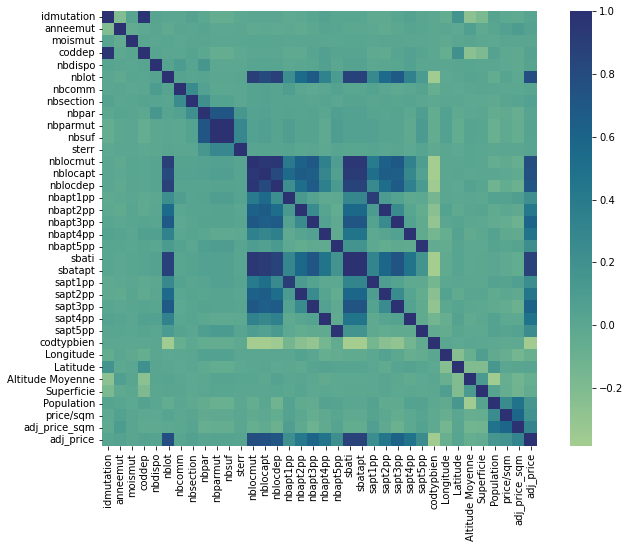

In [ ]:
# checking correlation
corr=train_num.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr,square=True,annot=False,cmap='crest')
plt.show()

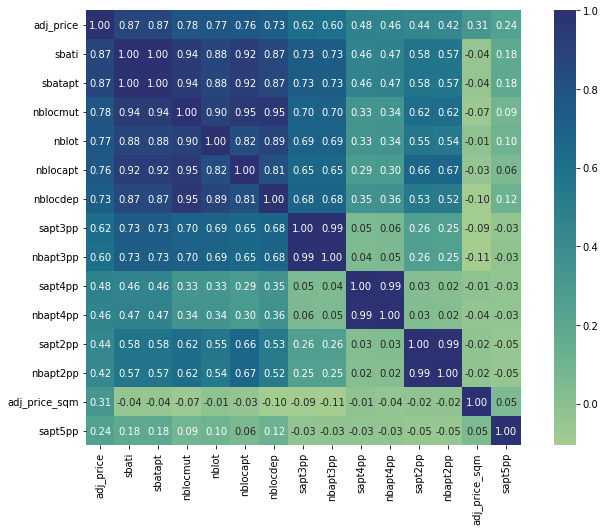

In [ ]:
# checking for top variables in term of correlation with price
k = 15 #number of variables for heatmap
cols = corr.nlargest(k, 'adj_price')['adj_price'].index
corr_10=corr.loc[cols,cols]
plt.figure(figsize=(12,8))
sns.heatmap(corr_10,annot=True,square=True,fmt='.2f', annot_kws={'size': 10},yticklabels=cols.values, xticklabels=cols.values,cmap='crest')
plt.show()

In [ ]:
# For each feature above, we check and eliminate correlated features
def delete_corr_features(reviewing_feature):
  filter_df = corr_10[[reviewing_feature]]
  list_70 = filter_df[filter_df[reviewing_feature]> 0.7]
  corr_list = list_70.index.to_list()
  corr_list.remove(reviewing_feature)
  price_val = 'adj_price'
  if price_val in corr_list:
    corr_list.remove('adj_price')

  for col in corr_list:
    train_num.drop(col,inplace=True,axis=1)
  return corr_list

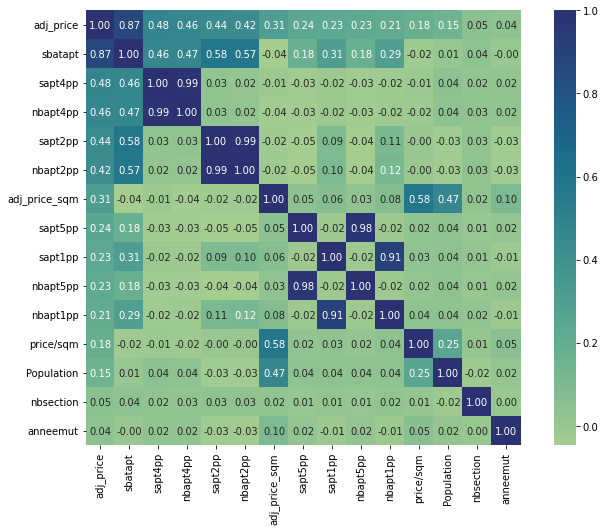

In [ ]:
del_col_1 = delete_corr_features('sbatapt')
corr=train_num.corr()
k = 15 #number of variables for heatmap
cols = corr.nlargest(k, 'adj_price')['adj_price'].index
corr_10=corr.loc[cols,cols]
plt.figure(figsize=(12,8))
sns.heatmap(corr_10,annot=True,square=True,fmt='.2f', annot_kws={'size': 10},yticklabels=cols.values, xticklabels=cols.values,cmap='crest')
plt.show()

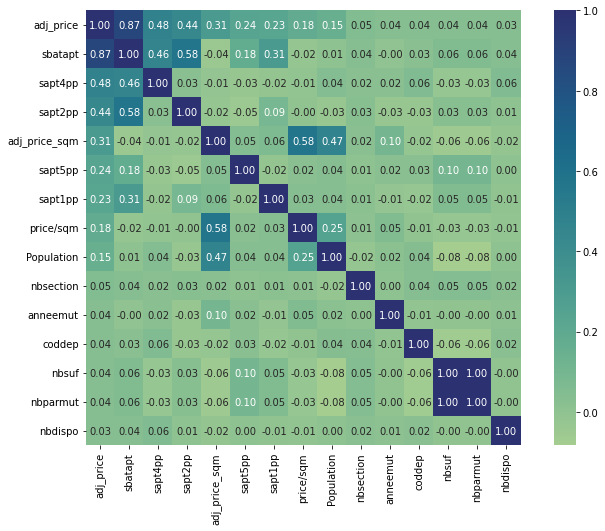

In [ ]:
# For each feature above, we check and eliminate correlated features
del_col_2 = delete_corr_features('sapt4pp') + delete_corr_features('sapt2pp') + delete_corr_features('sapt5pp')+ delete_corr_features('sapt1pp')
corr=train_num.corr()
k = 15 #number of variables for heatmap
cols = corr.nlargest(k, 'adj_price')['adj_price'].index
corr_10=corr.loc[cols,cols]
plt.figure(figsize=(12,8))
sns.heatmap(corr_10,annot=True,square=True,fmt='.2f', annot_kws={'size': 10},yticklabels=cols.values, xticklabels=cols.values,cmap='crest')
plt.show()

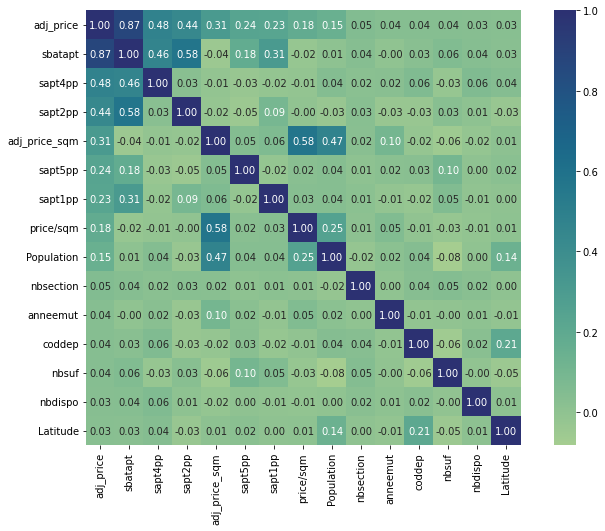

In [ ]:
# For each feature above, we check and eliminate correlated features
del_col_2 = delete_corr_features('nbsuf')
corr=train_num.corr()
k = 15 #number of variables for heatmap
cols = corr.nlargest(k, 'adj_price')['adj_price'].index
corr_10=corr.loc[cols,cols]
plt.figure(figsize=(12,8))
sns.heatmap(corr_10,annot=True,square=True,fmt='.2f', annot_kws={'size': 10},yticklabels=cols.values, xticklabels=cols.values,cmap='crest')
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


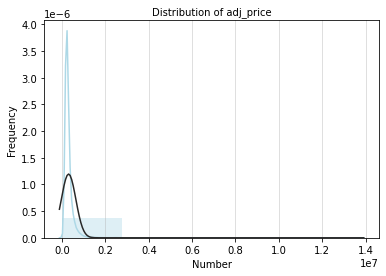

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


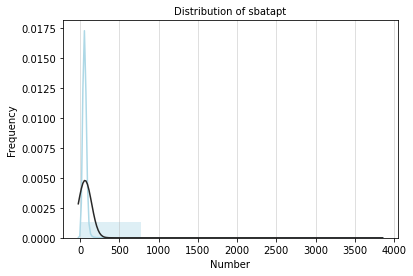

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


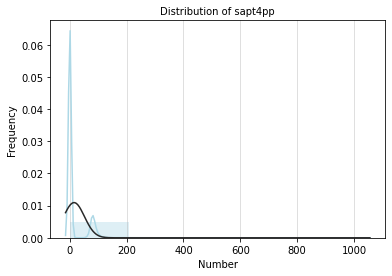

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


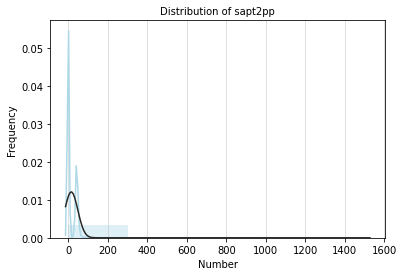

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


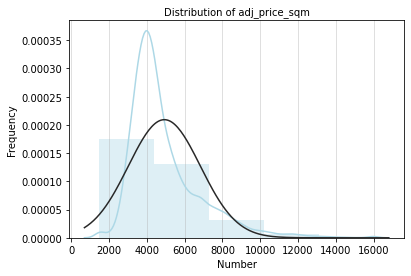

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


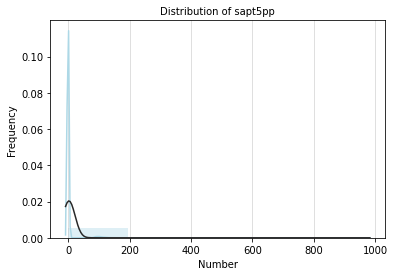

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


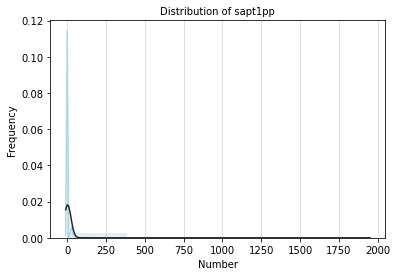

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


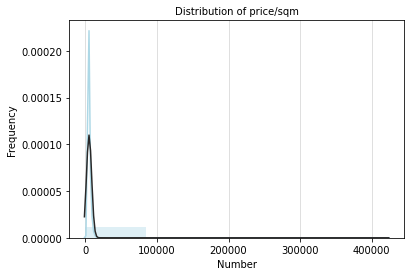

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


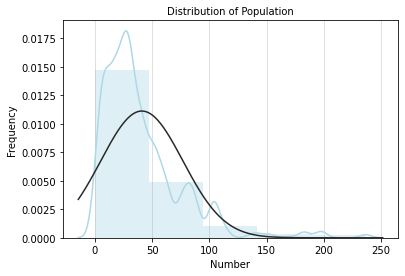

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


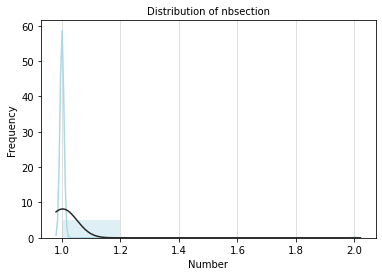

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


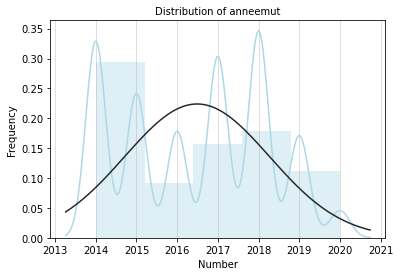

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


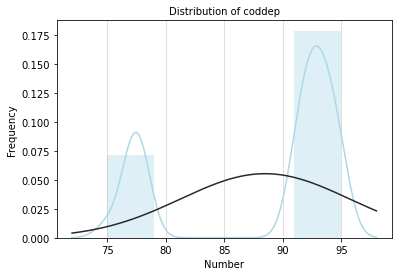

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


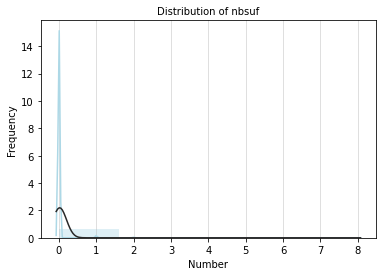

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


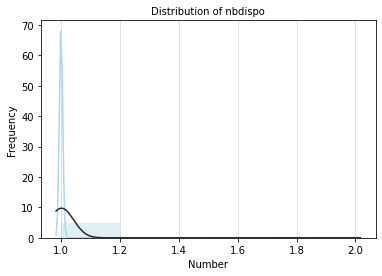

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


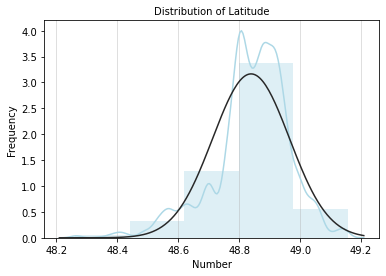

In [ ]:
# checking distribution of numerical variables
def distribution_plot(s):
  ''' Input: list of variables (column names) to plot
      Output: distribution plots the these variables
  '''
  sns.distplot(train_num[s], bins = 5, color = 'lightblue', fit=norm)
  plt.grid(axis='x', alpha=0.5) # Draw grids on the plot

  plt.xlabel('Number', size = 10)
  plt.ylabel('Frequency',size = 10)
  plt.title('Distribution of ' + s, size = 10)
  plt.show()

var = list(corr_10.columns)
for l in var:
  distribution_plot(l)

Text(0.5, 1.0, 'Price distribution for each year')

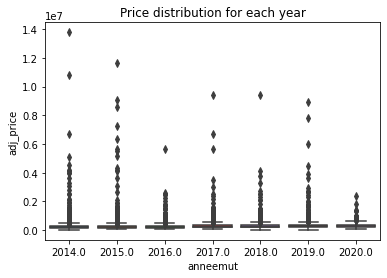

In [ ]:
# price by year
ax = sns.boxplot(data=map_df, x='anneemut', y='adj_price')
ax.set_title('Price distribution for each year')

Text(0.5, 1.0, 'Price distribution for each coddep')

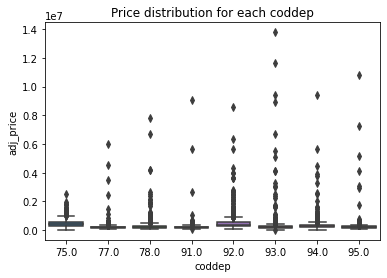

In [ ]:
# price by coddep
ax = sns.boxplot(data=map_df, x='coddep', y='adj_price')
ax.set_title('Price distribution for each coddep')

**Split data**

In [ ]:
# features to choose
feature_list =  ['sbatapt','Population','Longitude','Latitude','anneemut']
feature_df = map_df[feature_list]
feature_df

,sbatapt,Population,Longitude,Latitude,anneemut
511,29.0,152.7,2.377541,48.857669,2014.0
837,37.0,236.5,2.303706,48.831599,2017.0
1238,71.0,60.3,2.329696,48.880336,2018.0
1325,57.0,152.7,2.377541,48.857669,2015.0
1612,37.0,197.1,2.402686,48.864269,2016.0
...,...,...,...,...,...
1267052,27.0,3.3,2.501687,49.056879,2014.0
1267107,79.0,31.0,2.463663,49.036933,2020.0
1267111,61.0,57.2,2.026507,49.043154,2017.0
1267198,41.0,102.8,2.217414,48.940641,2014.0


In [ ]:
# split training & test set
X = feature_df.to_numpy()
y = map_df['adj_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Scale the data
scaler = preprocessing.MinMaxScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model

**Base models**

In [ ]:
# Linear regression
reg = LinearRegression()
reg.fit(X_train_scaled,y_train)
y_pred = reg.predict(X_test_scaled)
print("R2",r2_score(y_test, y_pred))
print("MAE",mean_absolute_error(y_test, y_pred))

R2 0.839241714485704
MAE 83060.37356510111


In [ ]:
# Linear regression with ridge
cross_val_scores_ridge = []
alpha = []
 
# Loop to compute the different values of cross-validation scores
for i in range(1, 9):
    ridgeModel = Ridge(alpha = i * 0.25)
    ridgeModel.fit(X_train_scaled, y_train)
    scores = cross_val_score(ridgeModel, X_train_scaled, y_train, cv = 5)
    avg_cross_val_score = mean(scores)
    cross_val_scores_ridge.append(avg_cross_val_score)
    alpha.append(i * 0.25)
 
# Loop to print the different values of cross-validation scores
for i in range(0, len(alpha)):
    print(str(alpha[i])+' : '+str(cross_val_scores_ridge[i]))

0.25 : 0.7153415305800064
0.5 : 0.7129189693290832
0.75 : 0.7085885452813112
1.0 : 0.7028326671399114
1.25 : 0.6960186300282007
1.5 : 0.688428165367016
1.75 : 0.6802786923822648
2.0 : 0.6717388117231796


In [ ]:
# Decision tree
dt = DecisionTreeRegressor()
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)
print("R2",r2_score(y_test, y_pred))
print("MAE",mean_absolute_error(y_test, y_pred))

R2 0.8904909906092916
MAE 41978.63011567626


**Ensemble models**

In [ ]:
# XGBoost
xgb_m = xgb.XGBRegressor()
xgb_m.fit(X_train_scaled, y_train)
y_pred = xgb_m.predict(X_test_scaled)
print("R2",r2_score(y_test, y_pred))
print("MAE",mean_absolute_error(y_test, y_pred))

[11:57:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R2 0.883092945507696
MAE 53041.826439010816


In [ ]:
# GradientBoosting
gb = GradientBoostingRegressor()
gb.fit(X_train,y_train)
y_pred = gb.predict(X_test)
print("R2",r2_score(y_test, y_pred))
print("MAE",mean_absolute_error(y_test, y_pred))

R2 0.871849477754965
MAE 52579.60922776228


In [ ]:
# Random forest
rf = RandomForestRegressor()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print("R2",r2_score(y_test, y_pred))
print("MAE",mean_absolute_error(y_test, y_pred))

R2 0.9058034544756562
MAE 35192.79232100923


In [ ]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# Tuning hyperparameters
param_grid = {
    'max_depth': [None, 100, 200, 500],
    'min_samples_leaf': [1, 3],
    'min_samples_split': [2, 4, 6, 8],
    'n_estimators': [100, 300, 500]}
rf_tuned = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)
rf_tuned.fit(X_train,y_train)
rf_tuned.best_params_

Fitting 5 folds for each of 96 candidates, totalling 480 fits


{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 500}

In [ ]:
# Check 5-folder cross validation result of model with best parameters 
print("Mean test score at best performed model:", rf_tuned.cv_results_['mean_test_score'][rf_tuned.best_index_])
print("Standard deviation of test score at best performed model:",rf_tuned.cv_results_['std_test_score'][rf_tuned.best_index_])

Mean test score at best performed model: 0.8538007888974513
Standard deviation of test score at best performed model: 0.060469118986084605


In [ ]:
# get the best model
best = RandomForestRegressor(max_depth= None,min_samples_leaf=1,min_samples_split=8,n_estimators=500) # fill the best parameters
best.fit(X_train,y_train)
y_pred = best.predict(X_test)
print("R2",r2_score(y_test, y_pred))
print("MAE",mean_absolute_error(y_test, y_pred))

R2 0.8936199075759388
MAE 36253.173475914205


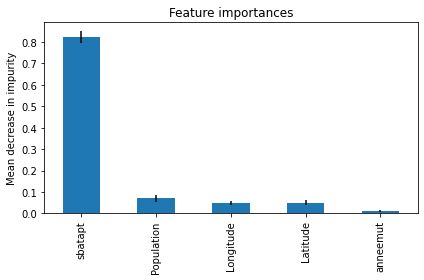

In [ ]:
# feature importance
importances = best.feature_importances_
std = np.std([tree.feature_importances_ for tree in best.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_list)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

**Do prediction on provided test set**

In [ ]:
# load the provided test data
test = pd.read_csv('test_set.csv',delimiter =";")
test = test.iloc[:,1:] # remove 2 index columns
test = test.drop(['codservch', 'refdoc'], axis=1)
test

,idmutation,idmutinvar,idopendata,idnatmut,datemut,anneemut,moismut,coddep,libnatmut,vefa,...,sapt5pp,smai1pp,smai2pp,smai3pp,smai4pp,smai5pp,codtypbien,libtypbien,longitude,latitude
0,6941661,3dc0e2cebe1170370a90bb295fcf8dfd,3dc0e2cebe1170370a90bb295fcf8dfd,2,735963,2015,12,75,Vente en l'état futur d'achèvement,True,...,0.0,0.0,0.0,0.0,0.0,0.0,121,UN APPARTEMENT,2.383744,48.842043
1,7078910,50ed582abf523e6c7e370312b4b6f6cc,50ed582abf523e6c7e370312b4b6f6cc,2,735432,2014,7,75,Vente en l'état futur d'achèvement,True,...,0.0,0.0,0.0,0.0,0.0,0.0,121,UN APPARTEMENT,2.324802,48.824812
2,7082228,9f79e19afc5b82b06523f1ff30eaa91a,9f79e19afc5b82b06523f1ff30eaa91a,2,735590,2014,12,75,Vente en l'état futur d'achèvement,True,...,0.0,0.0,0.0,0.0,0.0,0.0,121,UN APPARTEMENT,2.332064,48.825634
3,6947952,2996ec01aa9cc16702767bce70786655,2996ec01aa9cc16702767bce70786655,2,735653,2015,2,75,Vente en l'état futur d'achèvement,True,...,0.0,0.0,0.0,0.0,0.0,0.0,121,UN APPARTEMENT,2.324802,48.824812
4,6935795,e4920f4c2babb2a57be215b7c60356ae,e4920f4c2babb2a57be215b7c60356ae,2,735676,2015,3,75,Vente en l'état futur d'achèvement,True,...,0.0,0.0,0.0,0.0,0.0,0.0,121,UN APPARTEMENT,2.312209,48.827318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2762,8836137,03a9ac75eb47ad49059be6cd41c82c08,03a9ac75eb47ad49059be6cd41c82c08,2,735760,2015,6,95,Vente en l'état futur d'achèvement,True,...,0.0,0.0,0.0,0.0,0.0,0.0,121,UN APPARTEMENT,2.384100,49.004417
2763,8827740,302fbdfe6baf0422e3267251bd2fcdd1,302fbdfe6baf0422e3267251bd2fcdd1,2,735855,2015,9,95,Vente en l'état futur d'achèvement,True,...,0.0,0.0,0.0,0.0,0.0,0.0,121,UN APPARTEMENT,2.384100,49.004417
2764,8831376,db981bf7006608b184ff9148670ae8d7,db981bf7006608b184ff9148670ae8d7,2,735918,2015,11,95,Vente en l'état futur d'achèvement,True,...,0.0,0.0,0.0,0.0,0.0,0.0,121,UN APPARTEMENT,2.384100,49.004417
2765,8780683,055d685fc6a5f2d169851741c4d32f5c,055d685fc6a5f2d169851741c4d32f5c,2,736034,2016,3,95,Vente en l'état futur d'achèvement,True,...,0.0,0.0,0.0,0.0,0.0,0.0,121,UN APPARTEMENT,2.398633,49.003676


In [ ]:
# add price/ sqm => no outlier
test['price/sqm'] = test['valeurfonc']/test['sbatapt']
test["price/sqm"].describe()

count     2767.000000
mean      4630.554575
std       1506.614719
min       1822.368421
25%       3658.536585
50%       4258.333333
75%       5130.044593
max      14298.245614
Name: price/sqm, dtype: float64

In [ ]:
# add id_parcel_adj
test['id_parcel'] = test['l_idpar'].str.strip("['']")
split_id_parcel = test['id_parcel'].str.split("'",n = 1, expand = True)
test['id_parcel_adj'] = split_id_parcel[0]

In [ ]:
# add insee_code
test['insee_code'] = test['l_codinsee'].astype(str)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2767 entries, 0 to 2766
Data columns (total 62 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   idmutation     2767 non-null   int64  
 1   idmutinvar     2767 non-null   object 
 2   idopendata     2767 non-null   object 
 3   idnatmut       2767 non-null   int64  
 4   datemut        2767 non-null   int64  
 5   anneemut       2767 non-null   int64  
 6   moismut        2767 non-null   int64  
 7   coddep         2767 non-null   int64  
 8   libnatmut      2767 non-null   object 
 9   vefa           2767 non-null   bool   
 10  valeurfonc     2767 non-null   float64
 11  nbdispo        2767 non-null   int64  
 12  nblot          2767 non-null   int64  
 13  nbcomm         2767 non-null   int64  
 14  l_codinsee     2767 non-null   int64  
 15  nbsection      2767 non-null   int64  
 16  l_section      2767 non-null   object 
 17  nbpar          2767 non-null   int64  
 18  l_idpar 

In [ ]:
# map geolocalisation
map_test = pd.merge(test, parcel_map,how='left',left_on='id_parcel_adj', right_on='Identifiant de la parcelle cadastrale')
map_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2767 entries, 0 to 2766
Data columns (total 66 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   idmutation                             2767 non-null   int64  
 1   idmutinvar                             2767 non-null   object 
 2   idopendata                             2767 non-null   object 
 3   idnatmut                               2767 non-null   int64  
 4   datemut                                2767 non-null   int64  
 5   anneemut                               2767 non-null   int64  
 6   moismut                                2767 non-null   int64  
 7   coddep                                 2767 non-null   int64  
 8   libnatmut                              2767 non-null   object 
 9   vefa                                   2767 non-null   bool   
 10  valeurfonc                             2767 non-null   float64
 11  nbdi

In [ ]:
# check rows without geolocation info
map_test[map_test['Latitude'].isnull()]

,idmutation,idmutinvar,idopendata,idnatmut,datemut,anneemut,moismut,coddep,libnatmut,vefa,...,longitude,latitude,price/sqm,id_parcel,id_parcel_adj,insee_code,Identifiant de la parcelle cadastrale,Longitude,Latitude,Géolocalisation
848,8381989,ee435659fcc215c2ee04dfd44de1908e,ee435659fcc215c2ee04dfd44de1908e,2,735774,2015,6,91,Vente en l'état futur d'achèvement,True,...,2.301071,48.565675,3653.125000,"91376000AA0758', '91376000AA0815",91376000AA0758,91376,91376000AA0758,NaN,NaN,NaN
861,8138375,ac389f8df329eb568f0691b02c78a202,ac389f8df329eb568f0691b02c78a202,2,736782,2018,3,91,Vente en l'état futur d'achèvement,True,...,2.260157,48.729864,4493.670886,91377000BP0293,91377000BP0293,91377,91377000BP0293,NaN,NaN,NaN
868,8033657,9f52f073a29f634740ef438754158b14,9f52f073a29f634740ef438754158b14,2,737175,2019,4,91,Vente en l'état futur d'achèvement,True,...,2.260157,48.729864,4304.347826,91377000BP0293,91377000BP0293,91377,91377000BP0293,NaN,NaN,NaN
944,8146367,4b50cbb53328f3acd7d51ad44a81e342,4b50cbb53328f3acd7d51ad44a81e342,2,736712,2018,1,91,Vente en l'état futur d'achèvement,True,...,2.170927,48.683350,3048.234375,91692000BI0197,91692000BI0197,91692,91692000BI0197,NaN,NaN,NaN


In [ ]:
# check geolocalisation of adjacent parcels
parcel_map[(parcel_map['Identifiant de la parcelle cadastrale']=='91376000AA0757')|
           (parcel_map['Identifiant de la parcelle cadastrale']=='91377000BP0294')|
           (parcel_map['Identifiant de la parcelle cadastrale']=='91692000BI0195')]

,Identifiant de la parcelle cadastrale,Longitude,Latitude,Géolocalisation
56977,91376000AA0757,2.300312,48.565264,"48.565264, 2.300312"
332845,91692000BI0195,2.167723,48.682966,"48.682966, 2.167723"
350468,91377000BP0294,2.260750,48.732195,"48.732195, 2.26075"


In [ ]:
# update geolocolisation info for missing parcel_id
missing_parcel_id = pd.DataFrame({'Identifiant de la parcelle cadastrale': ["91376000AA0758", "91692000BI0197", "91377000BP0293"],
                    'Longitude': [2.300312, 2.167723, 2.260750],
                    'Latitude': [48.565264, 48.682966	, 48.732195],
                    'Géolocalisation': ["48.565264, 2.300312","48.682966, 2.167723","48.732195, 2.26075"]})
print(missing_parcel_id)
parcel_map1 = parcel_map.append(missing_parcel_id, ignore_index = True)
parcel_map1 = parcel_map1[parcel_map1['Longitude'].notna()]
parcel_map1.info()

  Identifiant de la parcelle cadastrale  Longitude   Latitude  \
0                        91376000AA0758   2.300312  48.565264   
1                        91692000BI0197   2.167723  48.682966   
2                        91377000BP0293   2.260750  48.732195   

       Géolocalisation  
0  48.565264, 2.300312  
1  48.682966, 2.167723  
2   48.732195, 2.26075  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 686574 entries, 0 to 709231
Data columns (total 4 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Identifiant de la parcelle cadastrale  686574 non-null  object 
 1   Longitude                              686574 non-null  float64
 2   Latitude                               686574 non-null  float64
 3   Géolocalisation                        686574 non-null  object 
dtypes: float64(2), object(2)
memory usage: 26.2+ MB


In [ ]:
# reupdate test data
mmap_test = pd.merge(test, parcel_map1,how='left',left_on='id_parcel_adj', right_on='Identifiant de la parcelle cadastrale')
mmap_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2767 entries, 0 to 2766
Data columns (total 66 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   idmutation                             2767 non-null   int64  
 1   idmutinvar                             2767 non-null   object 
 2   idopendata                             2767 non-null   object 
 3   idnatmut                               2767 non-null   int64  
 4   datemut                                2767 non-null   int64  
 5   anneemut                               2767 non-null   int64  
 6   moismut                                2767 non-null   int64  
 7   coddep                                 2767 non-null   int64  
 8   libnatmut                              2767 non-null   object 
 9   vefa                                   2767 non-null   bool   
 10  valeurfonc                             2767 non-null   float64
 11  nbdi

In [ ]:
# map population
mmap_test = pd.merge(mmap_test, insee_map,how='left',left_on='insee_code', right_on='Code INSEE')
mmap_test = mmap_test.drop(columns=['Identifiant de la parcelle cadastrale', 'Code INSEE'])

In [ ]:
# select features
feature_df = mmap_test[feature_list]
feature_df

,sbatapt,Population,Longitude,Latitude,anneemut
0,46.0,142.9,2.383643,48.842016,2015
1,63.0,137.2,2.324708,48.824885,2014
2,50.0,137.2,2.332045,48.825646,2014
3,96.0,137.2,2.324708,48.824885,2015
4,45.0,137.2,2.312235,48.827314,2015
...,...,...,...,...,...
2762,41.0,27.0,2.384111,49.004429,2015
2763,44.0,27.0,2.384111,49.004429,2015
2764,44.0,27.0,2.384111,49.004429,2015
2765,60.0,27.0,2.398808,49.003633,2016


In [ ]:
# split training & test set
X = feature_df.to_numpy()
print(X)
y = mmap_test['valeurfonc']
print(y)

[[  46.        142.9         2.383643   48.842016 2015.      ]
 [  63.        137.2         2.324708   48.824885 2014.      ]
 [  50.        137.2         2.332045   48.825646 2014.      ]
 ...
 [  44.         27.          2.384111   49.004429 2015.      ]
 [  60.         27.          2.398808   49.003633 2016.      ]
 [  48.         27.          2.414191   48.999584 2017.      ]]
0       460000.00
1       702341.14
2       412800.00
3       900000.00
4       471880.00
          ...    
2762    168000.00
2763    176000.00
2764    135525.00
2765    198000.00
2766    152000.00
Name: valeurfonc, Length: 2767, dtype: float64


In [ ]:
# prediction on test set using rf
y_pred = best.predict(X)
print("R2",r2_score(y, y_pred))
print("MAE",mean_absolute_error(y, y_pred))

R2 0.8532012198394275
MAE 31318.68605513125
